In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/forest-cover-type-prediction/test.csv
/kaggle/input/forest-cover-type-prediction/train.csv
/kaggle/input/forest-cover-type-prediction/sampleSubmission.csv


[original kernel](https://www.kaggle.com/nadare/eda-feature-engineering-and-modeling-4th-359)

# Summary
Stacking 10 models using LightGBM.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde


%matplotlib inline

# nadara's kenel

In [3]:
train_df = pd.read_csv('/kaggle/input/forest-cover-type-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/forest-cover-type-prediction/test.csv')
smpsb = pd.read_csv('/kaggle/input/forest-cover-type-prediction/sampleSubmission.csv')

### Preprocessing

#### EDA and LeaderBoard Hacking

In [4]:
print(train_df.columns)
print()
print(train_df.columns[1:11])

features_terrain = train_df.columns[1:11]

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

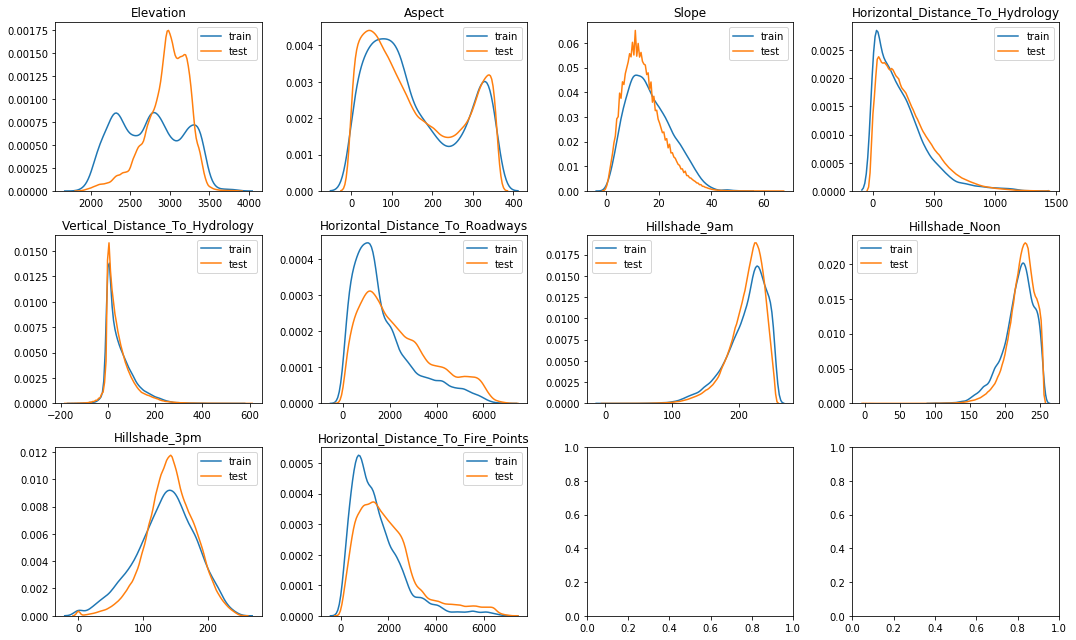

In [5]:
# First of all, let's see the distribution of each variable.
# You can see there is a big difference in distribution between
# training data and test data.


def compare_dist(ax, feature, train_df=train_df, test_df=test_df):
    sns.kdeplot(train_df[feature], label='train', ax=ax)
    sns.kdeplot(test_df[feature], label='test', ax=ax)
    

def numeric_tile(plot_func, features):
    base_size = 3
    fig, axes = plt.subplots(3, 4, figsize=(base_size*5, base_size*3))
    axes = axes.flatten()
    
    for i, (ax, col) in enumerate(zip(axes, features)):
        plot_func(ax, col)
        ax.set_title(col)
        
    plt.tight_layout()
    
    
numeric_tile(compare_dist, features_terrain)

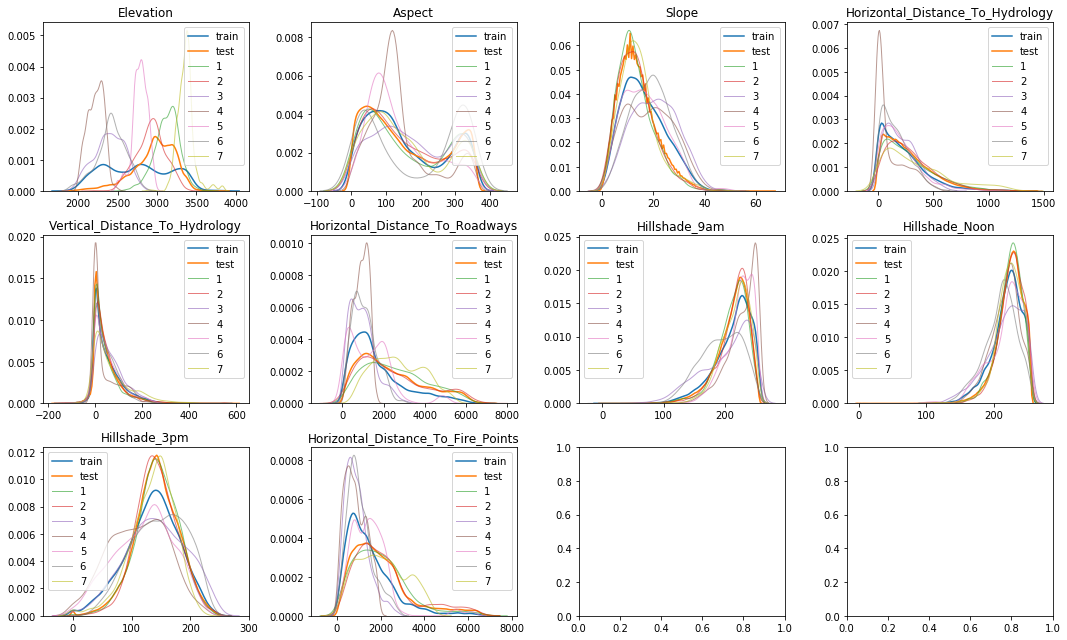

In [6]:
# For the training data, display the distribution of variables for each target.

# Please pay attention to `Elevation`. The difference between the training 
# data and the teset data distribution is thought to be due to the difference between
# the propertion of the target variabels in the training data and the test data.

def compare_target(ax, feature, train_df=train_df, test_df=test_df):
    sns.kdeplot(train_df.loc[:, feature], label='train', ax=ax)
    sns.kdeplot(test_df.loc[:, feature], label='test', ax=ax)
    
    for target in range(1, 7+1):
        indices = (train_df['Cover_Type'] == target)
        sns.kdeplot(train_df.loc[indices, feature], label=target,
                    alpha=0.6, lw=1, ax=ax)
        
        
numeric_tile(compare_target, features_terrain)

# LeaderBoard Probing
Hack the distribution of test dataset by submitting 7 times.

Reference: ["Problems occurring during validation" at 8:30](https://www.coursera.org/learn/competitive-data-science/lecture/8Rp3J/problems-occurring-during-validation)

In [13]:
# I was able to obtain the distribution of the test data by submitting prediction data with all the same purpose variables.

"""
smpsb = pd.read_csv('/kaggle/input/forest-cover-type-prediction/sampleSubmission.csv')

for i in range(1, 7+1):
    smpsb['Cover_Type'] = i
    smpsb.to_csv('all_{}.csv'.format(i), index=None)
"""

# The following is the magic number of this competition.
type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])

class_weight = {k: v for k, v in enumerate(type_ratio, start=1)}

print('class_weight={}'.format(class_weight))


class_weight={1: 0.37053, 2: 0.49681, 3: 0.05936, 4: 0.00103, 5: 0.01295, 6: 0.02687, 7: 0.03242}


### Demostrate how to make up a fake test data
Caveat: in the real situation, it only can make up 1 fake feature. 

Feature Elevation                          : min=1859, max=3858
Feature Aspect                             : min=0, max=360
Feature Slope                              : min=0, max=66
Feature Horizontal_Distance_To_Hydrology   : min=0, max=1397
Feature Vertical_Distance_To_Hydrology     : min=-173, max=601
Feature Horizontal_Distance_To_Roadways    : min=0, max=7117
Feature Hillshade_9am                      : min=0, max=254
Feature Hillshade_Noon                     : min=0, max=254
Feature Hillshade_3pm                      : min=0, max=254
Feature Horizontal_Distance_To_Fire_Points : min=0, max=7173


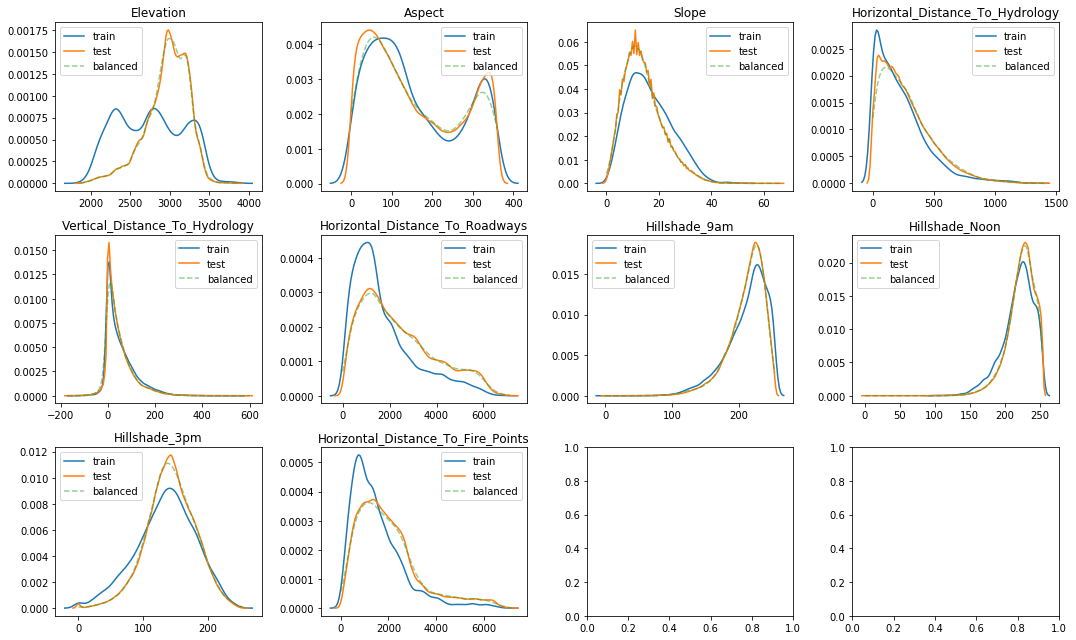

In [14]:
# By using these numbers, you can mimic the distribution of the test data from the training data.

def compare_balanced_dist(ax, feature, class_weight=class_weight):
    min_ = min(train_df[feature].min(),
              test_df[feature].min())
    
    max_ = max(train_df[feature].max(),
              test_df[feature].max())
    
    print('Feature {:35s}: min={}, max={}'.format(feature, min_, max_))
    
    X = np.linspace(min_, max_, 1000)
    
    sns.kdeplot(train_df[feature], label='train', ax=ax)
    sns.kdeplot(test_df[feature], label='test', ax=ax)
    btest = np.zeros(1000)
    
    for target in range(1, 7+1):
        indices = (train_df['Cover_Type'] == target)
        
        # Fit train data to a GMM (Gaussian mixture model)
        gaussian_kernel = gaussian_kde(train_df.loc[indices, feature])
        
        # generate PDF using GMM model, then accumlate weighted this PDF.
        btest += gaussian_kernel(X) * class_weight[target]
        
    ax.plot(X, btest, '--', label='balanced', alpha=0.5)
    ax.legend()
    
    
numeric_tile(compare_balanced_dist, features_terrain)

In [ ]:
# By using the following functions, it is possible to perform almost 
# the same evaluation as the leader board even in the local environment.

def balanced_accuracy_score(y_true, y_pred, class_weight=class_weight):
    weights_of_samples = np.apply_along_axis(lambda x: class_weight[x], 
                                                 axis=0, 
                                                 arr=y_true)
    
    return accuracy_score(y_true, y_pred,
                         sample_weight=weights_of_samples)

## Feature Engineering 1

#### Feature: `Aspect`

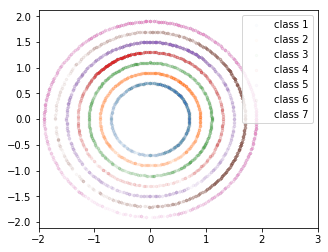

In [71]:
sin_ = np.sin(np.pi*train_df['Aspect']/180)
cos_ = np.cos(np.pi*train_df['Aspect']/180)

# However, if this feature quantity alone, the effect seems to be light.

fig, ax = plt.subplots(figsize=(5,4))


for i in range(1, 7+1):
    indices = (train_df['Cover_Type'] == i)
    
    r = 0.5+0.2*i
    
    ax.scatter(cos_[indices]*(r), 
                sin_[indices]*(r), 
                alpha=0.02*r, s=6, label='class {}'.format(i))
    
    
plt.xlim(-2, 3)
ax.legend()
# plt.savefig('aspect.png')